In [1]:
""" Created on February 16, 2023 // @author: Sarah Shi """

import numpy as np
import pandas as pd
import scipy
import random
import torch
import torch.nn as nn
from torch.nn.modules.activation import LeakyReLU, Sigmoid
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import os 
import time 
import json 
import pickle
import pygmt
import warnings

from scipy.sparse import (SparseEfficiencyWarning)
warnings.simplefilter('ignore', category=(FutureWarning,SparseEfficiencyWarning))
from scipy.special import softmax

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.preprocessing import scale, normalize, StandardScaler

import TAS as tas
import Thermobar as pt
import stoichiometry as mm

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.cm as mcm
import matplotlib.path as mpath
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import seaborn as sns 
import plotly.express as px

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('font',**{'family':'Avenir', 'size': 14})
plt.rcParams['pdf.fonttype'] = 42

pt.__version__

'1.0.10'

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


def save_model(model, optimizer, path):
    check_point = {'params': model.state_dict(),                            
                   'optimizer': optimizer.state_dict()}
    torch.save(check_point, path)

def load_model(model, optimizer=None, path=''):
    check_point = torch.load(path)
    model.load_state_dict(check_point['params'])
    if optimizer is not None:
        optimizer.load_state_dict(check_point['potimizer'])

def getLatent(model, dataset:np):
    #transform real data to latent space using the trained model
    latents=[]
    model.to(device)

    dataset_ = FeatureDataset(dataset)
    loader = DataLoader(dataset_,batch_size=20,shuffle=False)
    
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(loader):
            x = data.to(device)
            z = model.encoded(x)
            latents.append(z.detach().cpu().numpy())
    
    return np.concatenate(latents, axis=0)

def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [3]:
class FeatureDataset(Dataset):
    def __init__(self, x):
        if len(x.shape)==2:
            self.x = x
        else:
            self.x = x.reshape(-1, x.shape[-1]) #dataset keeps the right shape for training

    def __len__(self):
        return self.x.shape[0] 
    
    def __getitem__(self, n): 
        return torch.Tensor(self.x[n])


class Autoencoder(nn.Module):
    def __init__(self,input_dim = 10, latent_dim = 2, hidden_layer_sizes=(512, 256, 128)):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hls = hidden_layer_sizes

        def building_block(in_channel, out_channel):
            return [
                nn.Linear(in_channel, out_channel),
                nn.LayerNorm(out_channel),
                nn.LeakyReLU(0.02),
            ]

        encoder = building_block(self.input_dim, self.hls[0])
        for i in range(len(self.hls) - 1):
            encoder += building_block(self.hls[i], self.hls[i + 1])
        encoder += [nn.Linear(self.hls[-1], latent_dim)]

        decoder = building_block(latent_dim, self.hls[-1])
        for i in range(len(self.hls) - 1, 0, -1):
            decoder += building_block(self.hls[i], self.hls[i - 1])
        decoder += [nn.Linear(self.hls[0], self.input_dim)] # nn.Softmax()]

        self.encode = nn.Sequential(*encoder)
        self.decode = nn.Sequential(*decoder)

        self.apply(weights_init)

    def encoded(self, x):
        #encodes data to latent space
        return self.encode(x)

    def decoded(self, x):
        #decodes latent space data to 'real' space
        return self.decode(x)

    def forward(self, x):
        en = self.encoded(x)
        de = self.decoded(en)
        return de

class Tanh_Autoencoder(nn.Module):
    def __init__(self,input_dim = 10, latent_dim = 2, hidden_layer_sizes=(64, 32)):
        super(Tanh_Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hls = hidden_layer_sizes

        def building_block(in_channel, out_channel):
            return [
                nn.Linear(in_channel, out_channel),
                nn.LayerNorm(out_channel),
                nn.Tanh(),
            ]

        encoder = building_block(self.input_dim, self.hls[0])
        for i in range(len(self.hls) - 1):
            encoder += building_block(self.hls[i], self.hls[i + 1])
        encoder += [nn.Linear(self.hls[-1], latent_dim)]

        decoder = building_block(latent_dim, self.hls[-1])
        for i in range(len(self.hls) - 1, 0, -1):
            decoder += building_block(self.hls[i], self.hls[i - 1])
        decoder += [nn.Linear(self.hls[0], self.input_dim)] # nn.Softmax()]

        self.encode = nn.Sequential(*encoder)
        self.decode = nn.Sequential(*decoder)

        self.apply(weights_init)

    def encoded(self, x):
        #encodes data to latent space
        return self.encode(x)

    def decoded(self, x):
        #decodes latent space data to 'real' space
        return self.decode(x)

    def forward(self, x):
        en = self.encoded(x)
        de = self.decoded(en)
        return de

def train(model, optimizer, train_loader, test_loader, n_epoch, criterion):
    
    avg_total_loss = []
    avg_test_loss = []

    for epoch in range(n_epoch):
        # Training
        model.train()
        t = time.time()
        total_loss = []
        for i, data in enumerate(train_loader):
            x = data.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.detach().item())
        
        # Testing
        model.eval()
        test_loss = []
        for i, test in enumerate(test_loader):
            x = test.to(device)
            x_recon = model(x)
            loss = criterion(x_recon, x)
            test_loss.append(loss.detach().item())
        
        # Logging
        avg_loss = sum(total_loss) / len(total_loss)
        avg_test = sum(test_loss) / len(test_loss)
        avg_total_loss.append(avg_loss)
        avg_test_loss.append(avg_test)
        
        training_time = time.time() - t
        
        print(f'[{epoch+1:03}/{n_epoch:03}] train_loss: {avg_loss:.6f}, test_loss: {avg_test:.6f}, time: {training_time:.2f} s')

    return avg_total_loss, avg_test_loss

def autoencode(df, name, AE_Model, hidden_layer_sizes):

    dtypes = {'SiO2': float, 'TiO2': float, 'Al2O3': float, 'FeOT': float, 'Fe2O3T': float, 'FeOt': float, 'Fe2O3': float, 'MnO': float, 'MgO': float, 'CaO': float, 'Na2O': float, 'K2O': float, 'P2O5': float, 'Cr2O3': float, 'NiO': float}

    # df = pd.read_csv('TrainingData/' + name + '.csv', dtype = dtypes)
    oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']

    wt = df[oxides].fillna(0)
    mol = mm.calculate_mol_proportions(wt)
    wt = wt.to_numpy()
    mol = mol.to_numpy()

    #perform z-score normalisation
    array_norm_wt = normalize(wt)
    # array_norm_mol = normalize(mol)

    # array_norm = array_norm_mol 
    ss = StandardScaler()
    array_scale = ss.fit_transform(wt)

    array_norm = array_scale

    #split the dataset into train and test sets
    train_data, test_data = train_test_split(array_norm, test_size=0.1, stratify = df['Mineral'], random_state=42)

    #define datasets to be used with PyTorch - see autoencoder file for details
    feature_dataset = FeatureDataset(train_data)
    test_dataset = FeatureDataset(test_data)   

    #autoencoder params:
    lr = 5e-4
    wd = 0
    batch_size = 256
    epochs = 50
    input_size = feature_dataset.__getitem__(0).size(0)

    #define data loaders
    feature_loader = DataLoader(feature_dataset, batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
    np.savez(name + '_features.npz', feature_loader = feature_loader, test_loader = test_loader)

    #define model
    model = AE_Model(input_dim=input_size, hidden_layer_sizes = hidden_layer_sizes).to(device)

    #use ADAM optimizer with mean squared error loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=wd) 
    criterion = nn.MSELoss()

    #train model using pre-defined function
    train_loss, test_loss = train(model, optimizer, feature_loader, test_loader, epochs, criterion)
    np.savez(name + '_tanh_loss.npz', train_loss = train_loss, test_loss = test_loss)

    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    ax = ax.flatten()
    ax[0].plot(np.linspace(1, epochs, epochs), train_loss, '.-', label = 'Train Loss')
    ax[0].plot(np.linspace(1, epochs, epochs), test_loss, '.-', label = 'Test Loss')
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(prop={'size': 10})

    #transform entire dataset to latent space
    z = getLatent(model, array_norm)
    phase = list(set(df.Mineral))
    tab = plt.get_cmap('tab20')
    cNorm  = mcolors.Normalize(vmin=0, vmax=len(phase))
    scalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)

    # plot latent representation
    for i in range(len(phase)):
        indx = df['Mineral'] == phase[i]
        ax[1].scatter(z[indx, 0], z[indx, 1], s=15, color=scalarMap.to_rgba(i), lw=1, label=phase[i], rasterized = True)
    ax[1].set_xlabel("Latent Variable 1")
    ax[1].set_ylabel("Latent Variable 2")
    ax[1].set_title(name + " Latent Space Representation")
    ax[1].legend(prop={'size': 8})
    plt.tight_layout()
    plt.savefig(name + '_loss_latentspace.pdf',)

    # save main model params
    model_path = name + "_tanh_params.pt"
    save_model(model, optimizer, model_path)

    # save all other params
    conc_file = name + "_tanh.npz"
    np.savez(name + "_tanh.npz", batch_size = batch_size, epochs = epochs, input_size = input_size, 
            conc_file = conc_file, z = z)

    return z 

In [4]:
class FeatureDataset_nn(Dataset):
    def __init__(self, x, labels):
        if len(x.shape)==2:
            self.x = x
            self.labels = labels
        else:
            self.x = x.reshape(-1, x.shape[-1]) #dataset keeps the right shape for training
            self.labels = labels

    def __len__(self):
        return len(self.x) 
    
    def __getitem__(self, n): 
        return torch.Tensor(self.x[n]), torch.LongTensor(self.labels[n])


class MultiClassClassifier(nn.Module):
    def __init__(self, input_dim = 10, latent_dim = 2, hidden_layer_sizes = (128, 64)):
        super(MultiClassClassifier, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hls = hidden_layer_sizes

        def building_block(in_channel, out_channel):
            return [
                nn.Linear(in_channel, out_channel),
                nn.LeakyReLU(0.02),
            ]

        encoder = building_block(self.input_dim, self.hls[0])
        for i in range(len(self.hls) - 1):
            encoder += building_block(self.hls[i], self.hls[i + 1])
        encoder += [nn.Linear(self.hls[-1], latent_dim)]

        self.encode = nn.Sequential(*encoder)
        self.apply(weights_init)

    def encoded(self, x):
        #encodes data to latent space
        return self.encode(x)

    def forward(self, x):
        en = self.encoded(x)
        return en


def train_nn(model, optimizer, label, train_loader, test_loader, n_epoch, criterion):

    avg_total_loss = []
    avg_test_loss = []

    for epoch in range(n_epoch):
        # Training
        model.train()
        t = time.time()
        total_loss = []
        for i, (data, labels) in enumerate(train_loader):
            x = data.to(device)
            output = model(x)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.detach().item())
        
        # Testing
        model.eval()
        test_loss = []
        for i, (data, labels) in enumerate(test_loader):
            x = test.to(device)
            output = model(x)
            loss = criterion(output, labels)
            test_loss.append(loss.detach().item())
        
        # Logging
        avg_loss = sum(total_loss) / len(total_loss)
        avg_test = sum(test_loss) / len(test_loss)
        avg_total_loss.append(avg_loss)
        avg_test_loss.append(avg_test)
        
        training_time = time.time() - t
        
        print(f'[{epoch+1:03}/{n_epoch:03}] train_loss: {avg_loss:.6f}, test_loss: {avg_test:.6f}, time: {training_time:.2f} s')

    return avg_total_loss, avg_test_loss


def neuralnetwork(df, name, hidden_layer_sizes): 

    dtypes = {'SiO2': float, 'TiO2': float, 'Al2O3': float, 'FeOT': float, 'Fe2O3T': float, 'FeOt': float, 'Fe2O3': float, 'MnO': float, 'MgO': float, 'CaO': float, 'Na2O': float, 'K2O': float, 'P2O5': float, 'Cr2O3': float, 'NiO': float}

    # df = pd.read_csv('TrainingData/' + name + '.csv', dtype = dtypes)
    oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
    label = ['Mineral']

    min = df[label]
    wt = df[oxides].fillna(0)
    wt = wt.to_numpy()

    ss = StandardScaler()
    array_scale = ss.fit_transform(wt)

    array_norm = array_scale

    #split the dataset into train and test sets
    train_data_x, train_data_y, test_data_x, test_data_y = train_test_split(array_norm, min, test_size=0.1, stratify = df['Mineral'], random_state=42)

    #define datasets to be used with PyTorch - see autoencoder file for details
    feature_dataset = FeatureDataset_nn(train_data_x, train_data_y)
    test_dataset = FeatureDataset_nn(test_data_x, test_data_y)

    #autoencoder params:
    lr = 5e-4
    wd = 0
    batch_size = 256
    epochs = 50
    input_size = len(feature_dataset.__getitem__(0))


    #define data loaders
    feature_loader = DataLoader(feature_dataset, batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
    np.savez(name + '_features.npz', feature_loader = feature_loader, test_loader = test_loader)


    # Initialize model
    model = MultiClassClassifier(input_dim=input_size, hidden_layer_sizes = hidden_layer_sizes).to(device)

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=wd) 
    criterion = nn.MSELoss()

    # model, optimizer, label, train_loader, test_loader, n_epoch, criterion    

    #train model using pre-defined function
    train_loss, test_loss = train_nn(model, optimizer, label, feature_loader, test_loader, epochs, criterion)
    np.savez(name + '_nn_loss.npz', train_loss = train_loss, test_loss = test_loss)

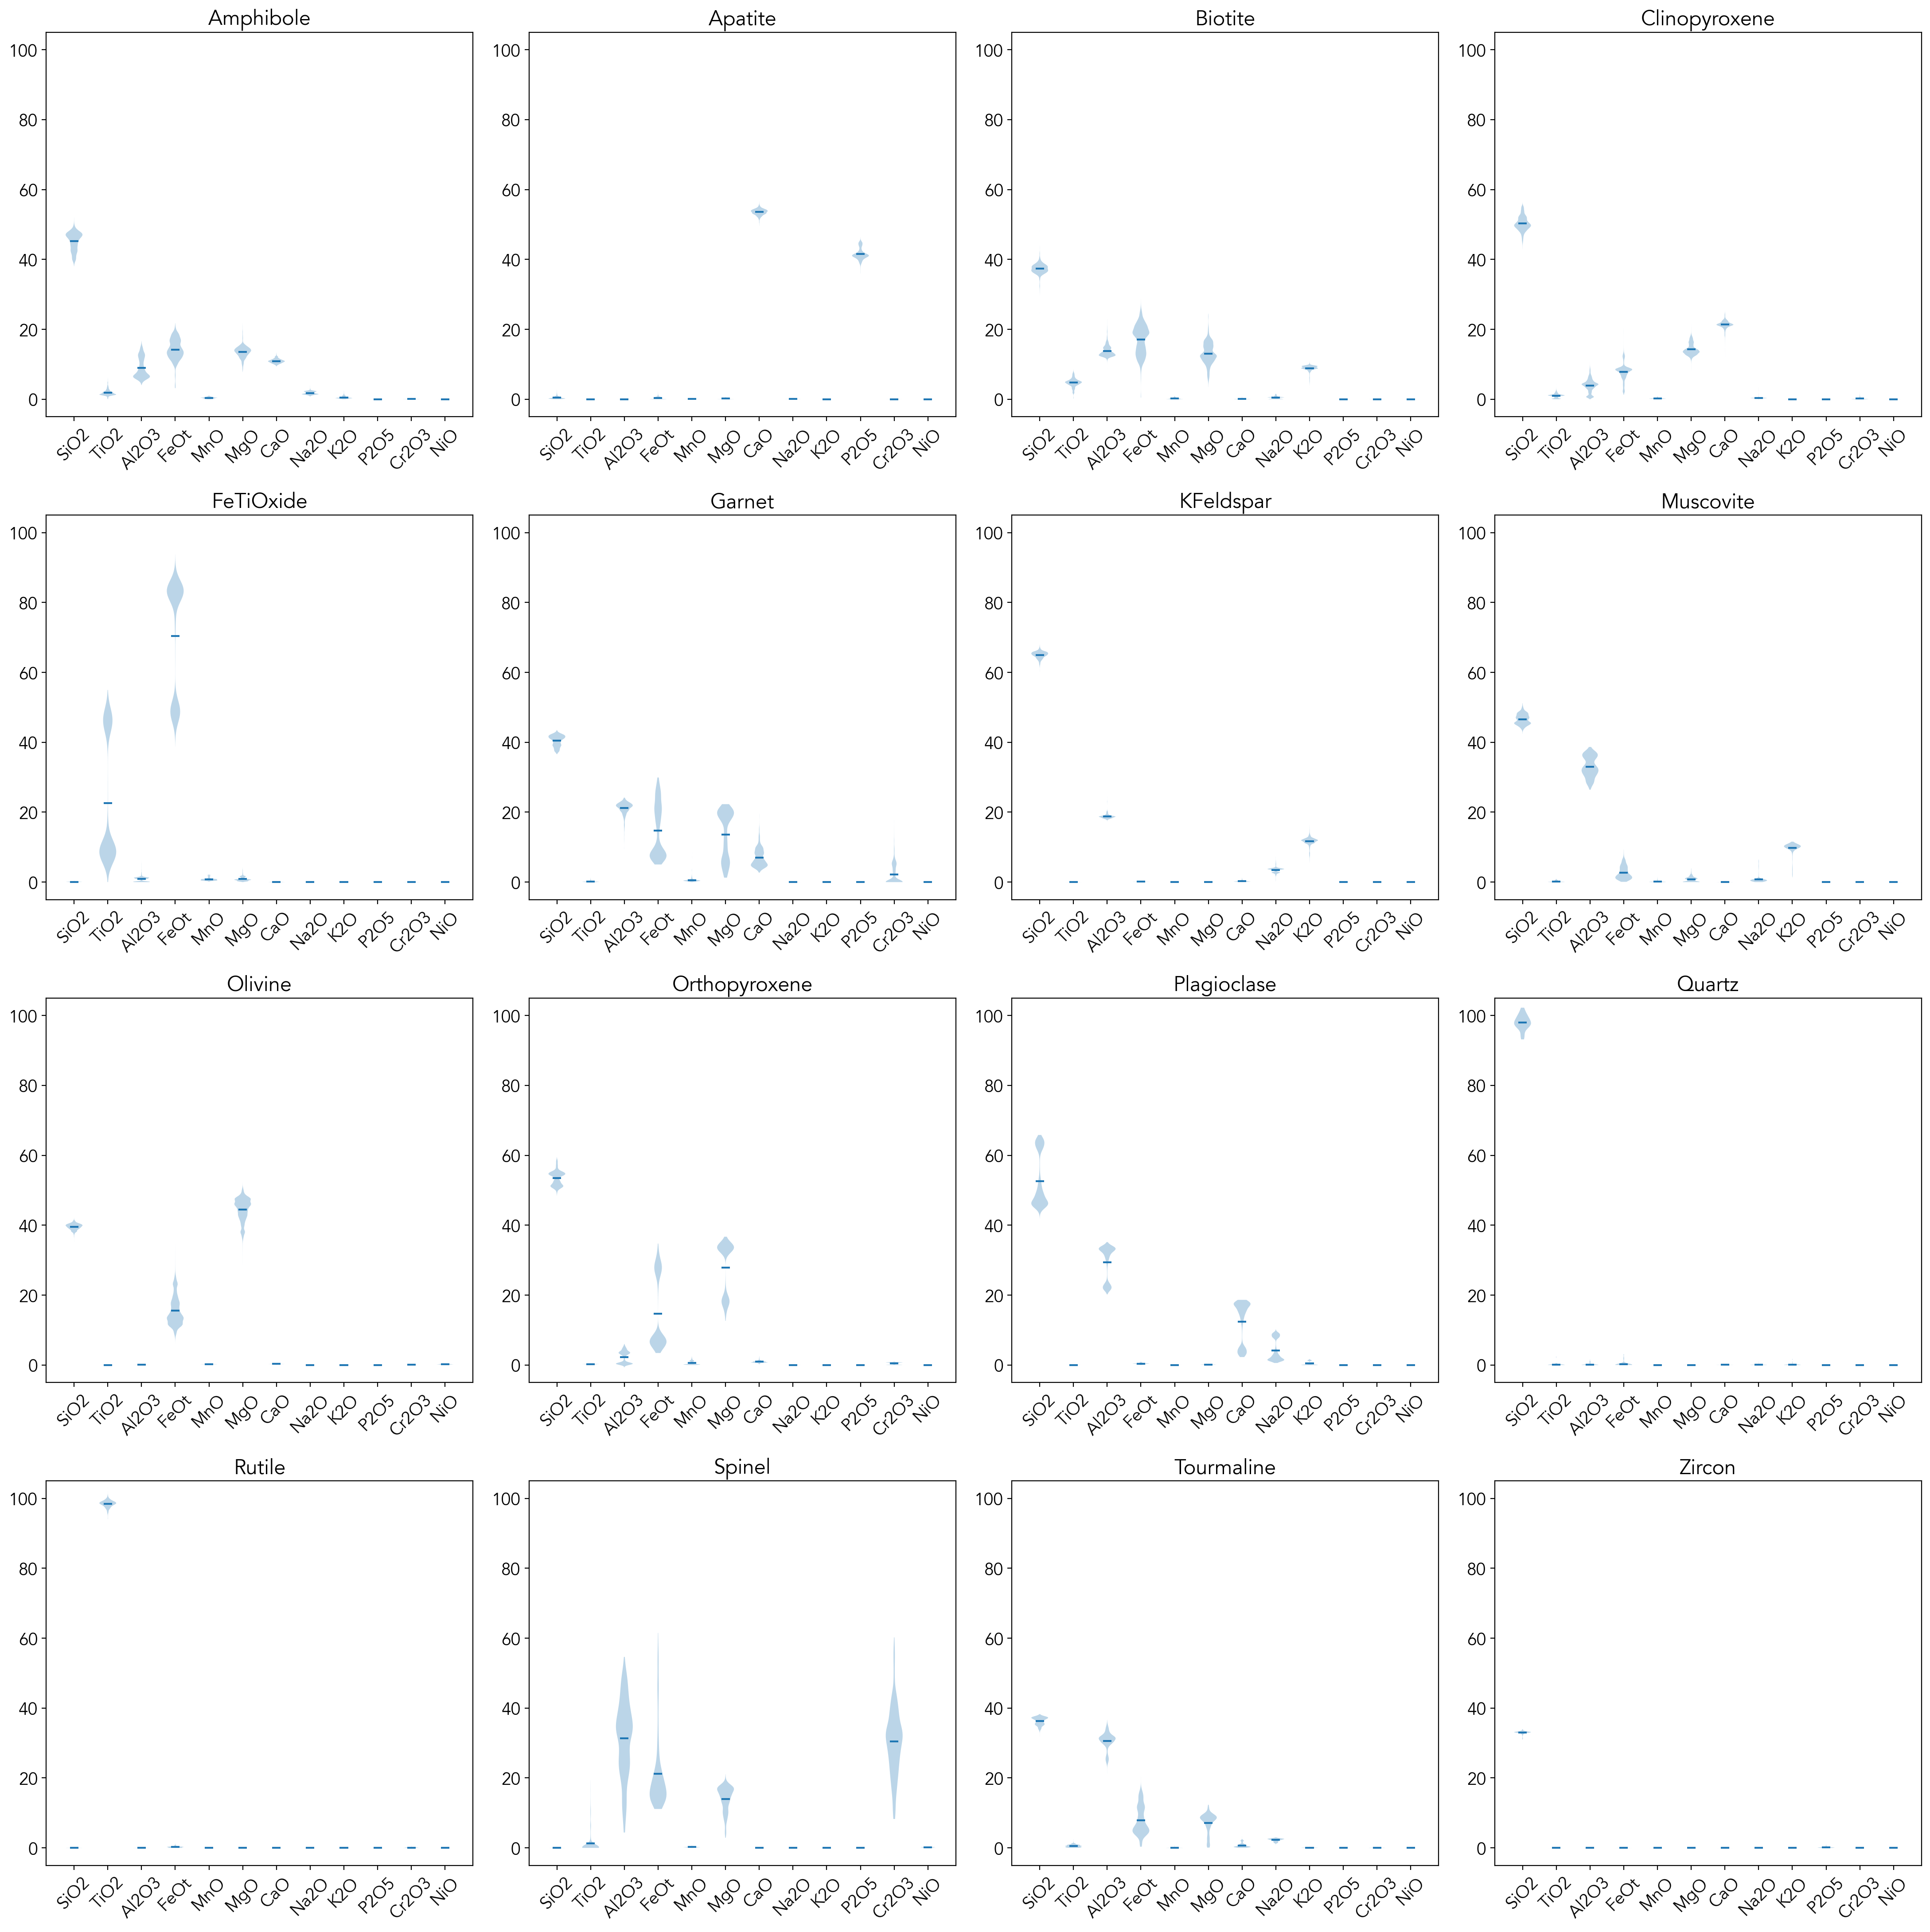

In [5]:
min_df = pd.read_csv('TrainingData/mindf_filt.csv')

oxideslab = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'P2O5', 'Cr2O3', 'NiO', 'Mineral']
oxides = oxideslab[:-1]

df = min_df[oxideslab].copy()
df = df.fillna(0)
df_ox = df[oxides]
mins = np.unique(df['Mineral'])

fig, ax = plt.subplots(4, 4, figsize=(22, 22))
ax = ax.flatten()
for i in range(len(mins)): 
    ax[i].violinplot(df[df['Mineral']==mins[i]][oxides], positions = np.linspace(0, 11, 12), showmeans = True, showextrema= False)
    ax[i].set_title(mins[i])
    ax[i].set_xticks(np.linspace(0, 11, 12))
    ax[i].set_xticklabels(oxides, rotation = 45)
    ax[i].set_ylim([-5, 105])
plt.tight_layout()

meta NOT subset; don't know how to subset; dropped


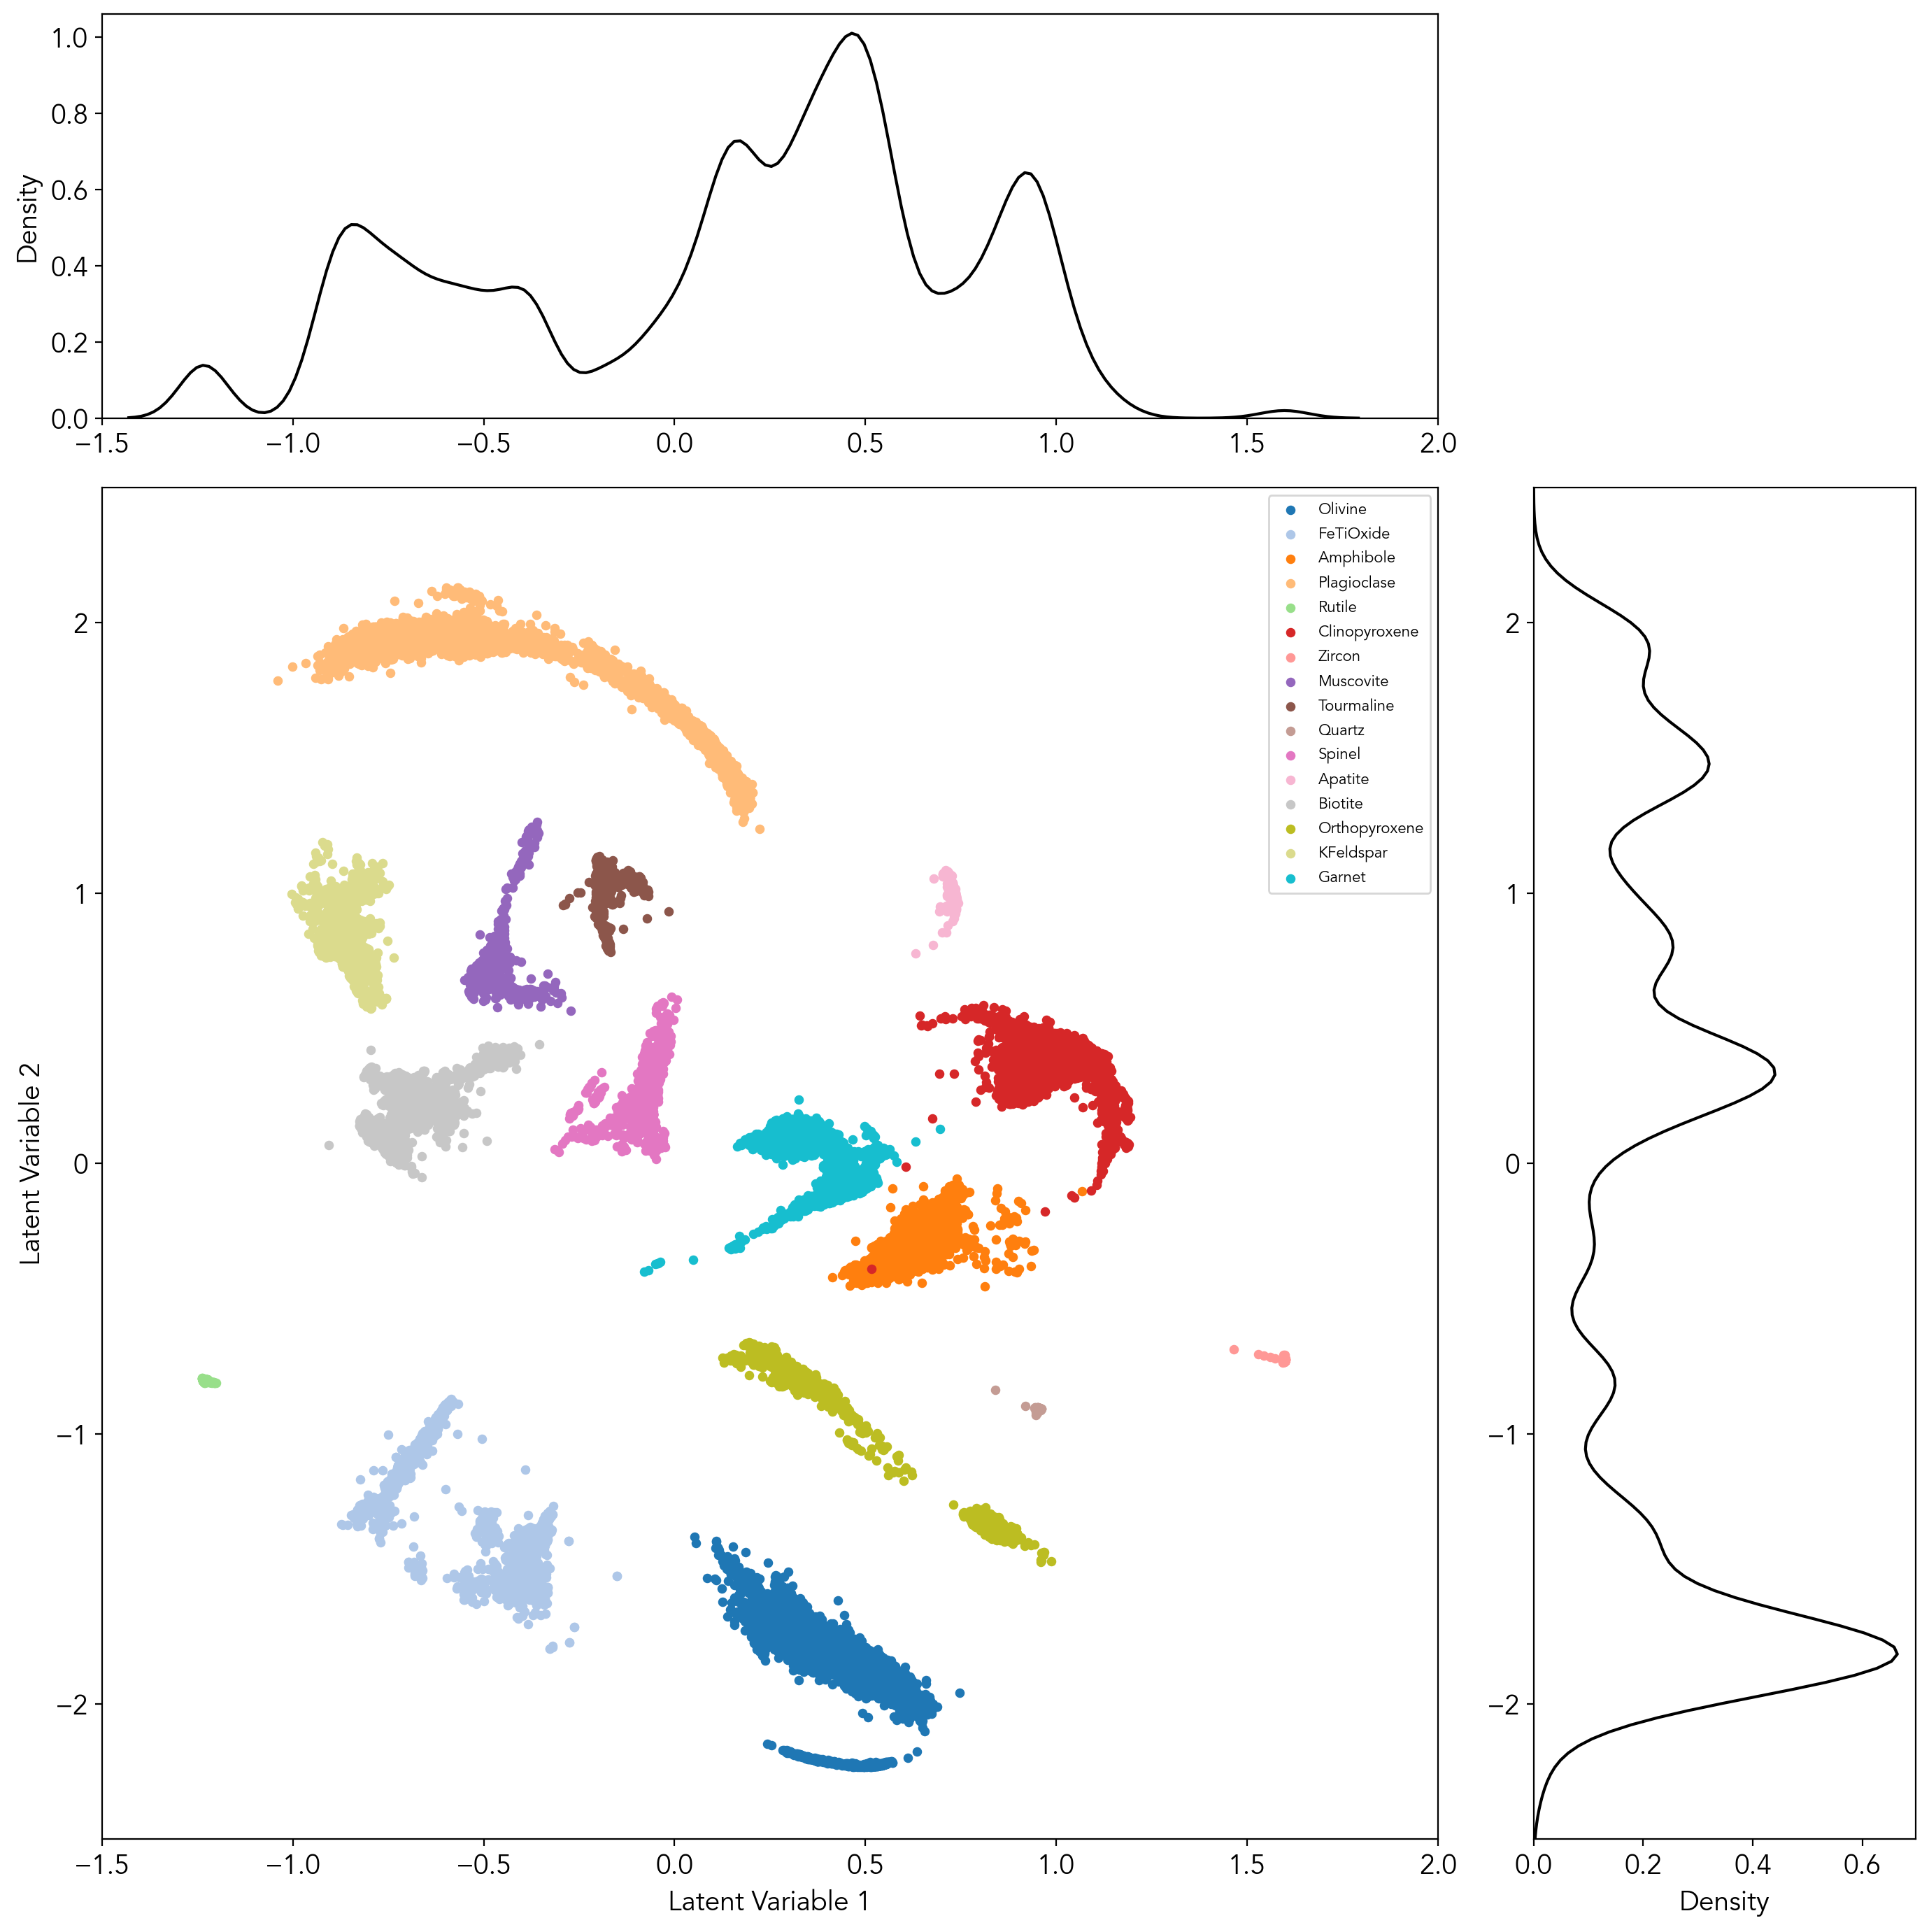

In [6]:
name = 'mindf_256_64_16'

z = np.load('ParameterMatrix/' + name + '_tanh.npz')['z']

z_scores_df = pd.DataFrame(columns = ['LV1', 'LV2']) 
z_scores_df['LV1'] = z[:,0]
z_scores_df['LV2'] = z[:,1]

fig = plt.figure(figsize = (14, 14))
gs = GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

phase = list(set(df['Mineral']))
tab = plt.get_cmap('tab20')
cNorm  = mcolors.Normalize(vmin=0, vmax=len(phase))
scalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)

for i in range(len(phase)):
    indx = df['Mineral'] == phase[i]
    ax_scatter.scatter(z[indx, 0], z[indx, 1], s=15, color=scalarMap.to_rgba(i), lw=1, label=phase[i])
ax_scatter.set_xlabel("Latent Variable 1")
ax_scatter.set_ylabel("Latent Variable 2")
ax_scatter.set_xlim([-1.5, 2.0])
ax_scatter.set_ylim([-2.5, 2.5])
ax_scatter.legend(prop={'size': 8})

pc1_sns = sns.kdeplot(data = z_scores_df, x = 'LV1', color = 'k', ax = ax_hist_x)
pc1_sns.set_xlim([-1.5, 2.0])
pc1_sns.set(xlabel = None)

pc2_sns = sns.kdeplot(data = z_scores_df, y = 'LV2', color = 'k')
pc2_sns.set_ylim([-2.5, 2.5])
pc2_sns.set(ylabel = None)

plt.tight_layout()
plt.savefig(name + "_density.pdf")

In [7]:
# let's try some clustering on this unsupervised dataset 

def feature_normalisation(feature, return_params = False, mean_norm = True):
    """
    Function to perform mean normalisation on the dataset passed to it.
    
    Input
    ----------
    feature (numpy array) - features to be normalised
    return_params (boolean, optional) - set True if parameters used for mean normalisation
                            are to be returned for each feature
                            
    Returns
    ----------
    norm (numpy array) - mean normalised features
    params (list of numpy arrays) - only returned if set to True above; list of parameters
                            used for the mean normalisation as derived from the features
                            (ie. mean, min and max).
    """
    
    params = []
    
    norm = np.zeros_like(feature)
    
    if len(feature.shape) == 2:
        for i in range(feature.shape[1]):
            if mean_norm == True:
                temp_mean = feature[:,i].mean()
            elif mean_norm == False:
                temp_mean = 0
            else:
                raise ValueError("Mean_norm must be boolean")
            norm[:,i] = (feature[:,i] - temp_mean) / (feature[:,i].max() - feature[:,i].min())
            params.append(np.asarray([temp_mean,feature[:,i].min(),feature[:,i].max()]))
    
    elif len(feature.shape) == 1:
        if mean_norm == True:
            temp_mean = feature[:].mean()
        elif mean_norm == False:
                temp_mean = 0
        else:
            raise ValueError("Mean_norm must be boolean")
        norm[:] = (feature[:] - temp_mean) / (feature.max() - feature.min())
        params.append(np.asarray([temp_mean,feature[:].min(),feature[:].max()]))
        
    else:
        raise ValueError("Feature array must be either 1D or 2D numpy array.")
        
    
    if return_params == True:
        return norm, params
    else:
        return norm

def cluster(data, n_clusters, method, plot = False, plot_return = False, elements = None,
    df_shape = None):
    
    """
    Function to perform clustering on the dataset passed using the selected clustering
    algorithm.
    
    Input
    ------------
    data (either 2D or 3D numpy array) - the dataset to perform clustering on.
    n_clusters (int) - number of clusters to find, default is 2.
    method (str) - clustering algorithm to be used ["k_means", "gmm"]; default is k_means.
    plot (bool) - Make True if results are to be plotted; default is false.
    plot_return (bool) - optional, if plot=true, make True to return fig and ax objects, default is false.
    elements (list/array) - optional, used when plotting results only, default is None.
    
    Return
    ------------
    labels (2D numpy array) - assigned labels for each cluster found within the passed dataset. 
        Shape is the same as first two dimensions of data if it's 3D, otherwise it's
        the shape parameter passed to the function.
    centers (2D numpy array of shape [n_clusters, n_features]) - list of the centres of clusters
        found in the dataset.
    fig, ax (matplotlib objects (both of length 2)) - only if both plot and plot_return are set True.
    """
    
    if len(data.shape) == 2:
        #assume it's in the right form
        array = data
    else:
        raise ValueError("Input array needs to have 2 dimensions or be Pandas dataframe.")

    array, params = feature_normalisation(array, return_params = True)

    start = time.time()
    
    if method.lower() == "gmm":
        from sklearn.mixture import GaussianMixture
        #perform GMM
        gmm = GaussianMixture(n_clusters)
        labels = gmm.fit_predict(array) + 1
        centers = gmm.means_

    elif method.lower() == "k_means":
        from sklearn.cluster import KMeans
        #perform k_means clustering
        kmeans = KMeans(n_clusters=n_clusters, init = 'k-means++').fit(array)
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_

    elif method.lower() == "b-gmm":
        from sklearn.mixture import BayesianGaussianMixture
        #perform b-gmm
        bgm = BayesianGaussianMixture(n_components = n_clusters, covariance_type = 'full', init_params = 'kmeans', max_iter = 500, random_state=42)
        labels = bgm.fit_predict(array)
        centers = bgm.means_

    elif method.lower() == "dbscan":
        from sklearn.cluster import DBSCAN
        #perform b-gmm
        dbscan = DBSCAN(eps = 0.025, min_samples = 100).fit(array)
        labels = dbscan.labels_

    else:
        raise ValueError("Method " + str(method) + " is not recognised.")
        
    process_time = time.time() - start    
    print("Clustering processing time (s): " + str(process_time))
        
    if plot == True:
        fig, ax = plot_cluster(labels, centers, plot_return = True, elements=elements)
        if plot_return == True:
            return labels, centers, fig, ax
        else:
            pass
    else:
        pass
    
    return labels

Clustering processing time (s): 9.869099140167236


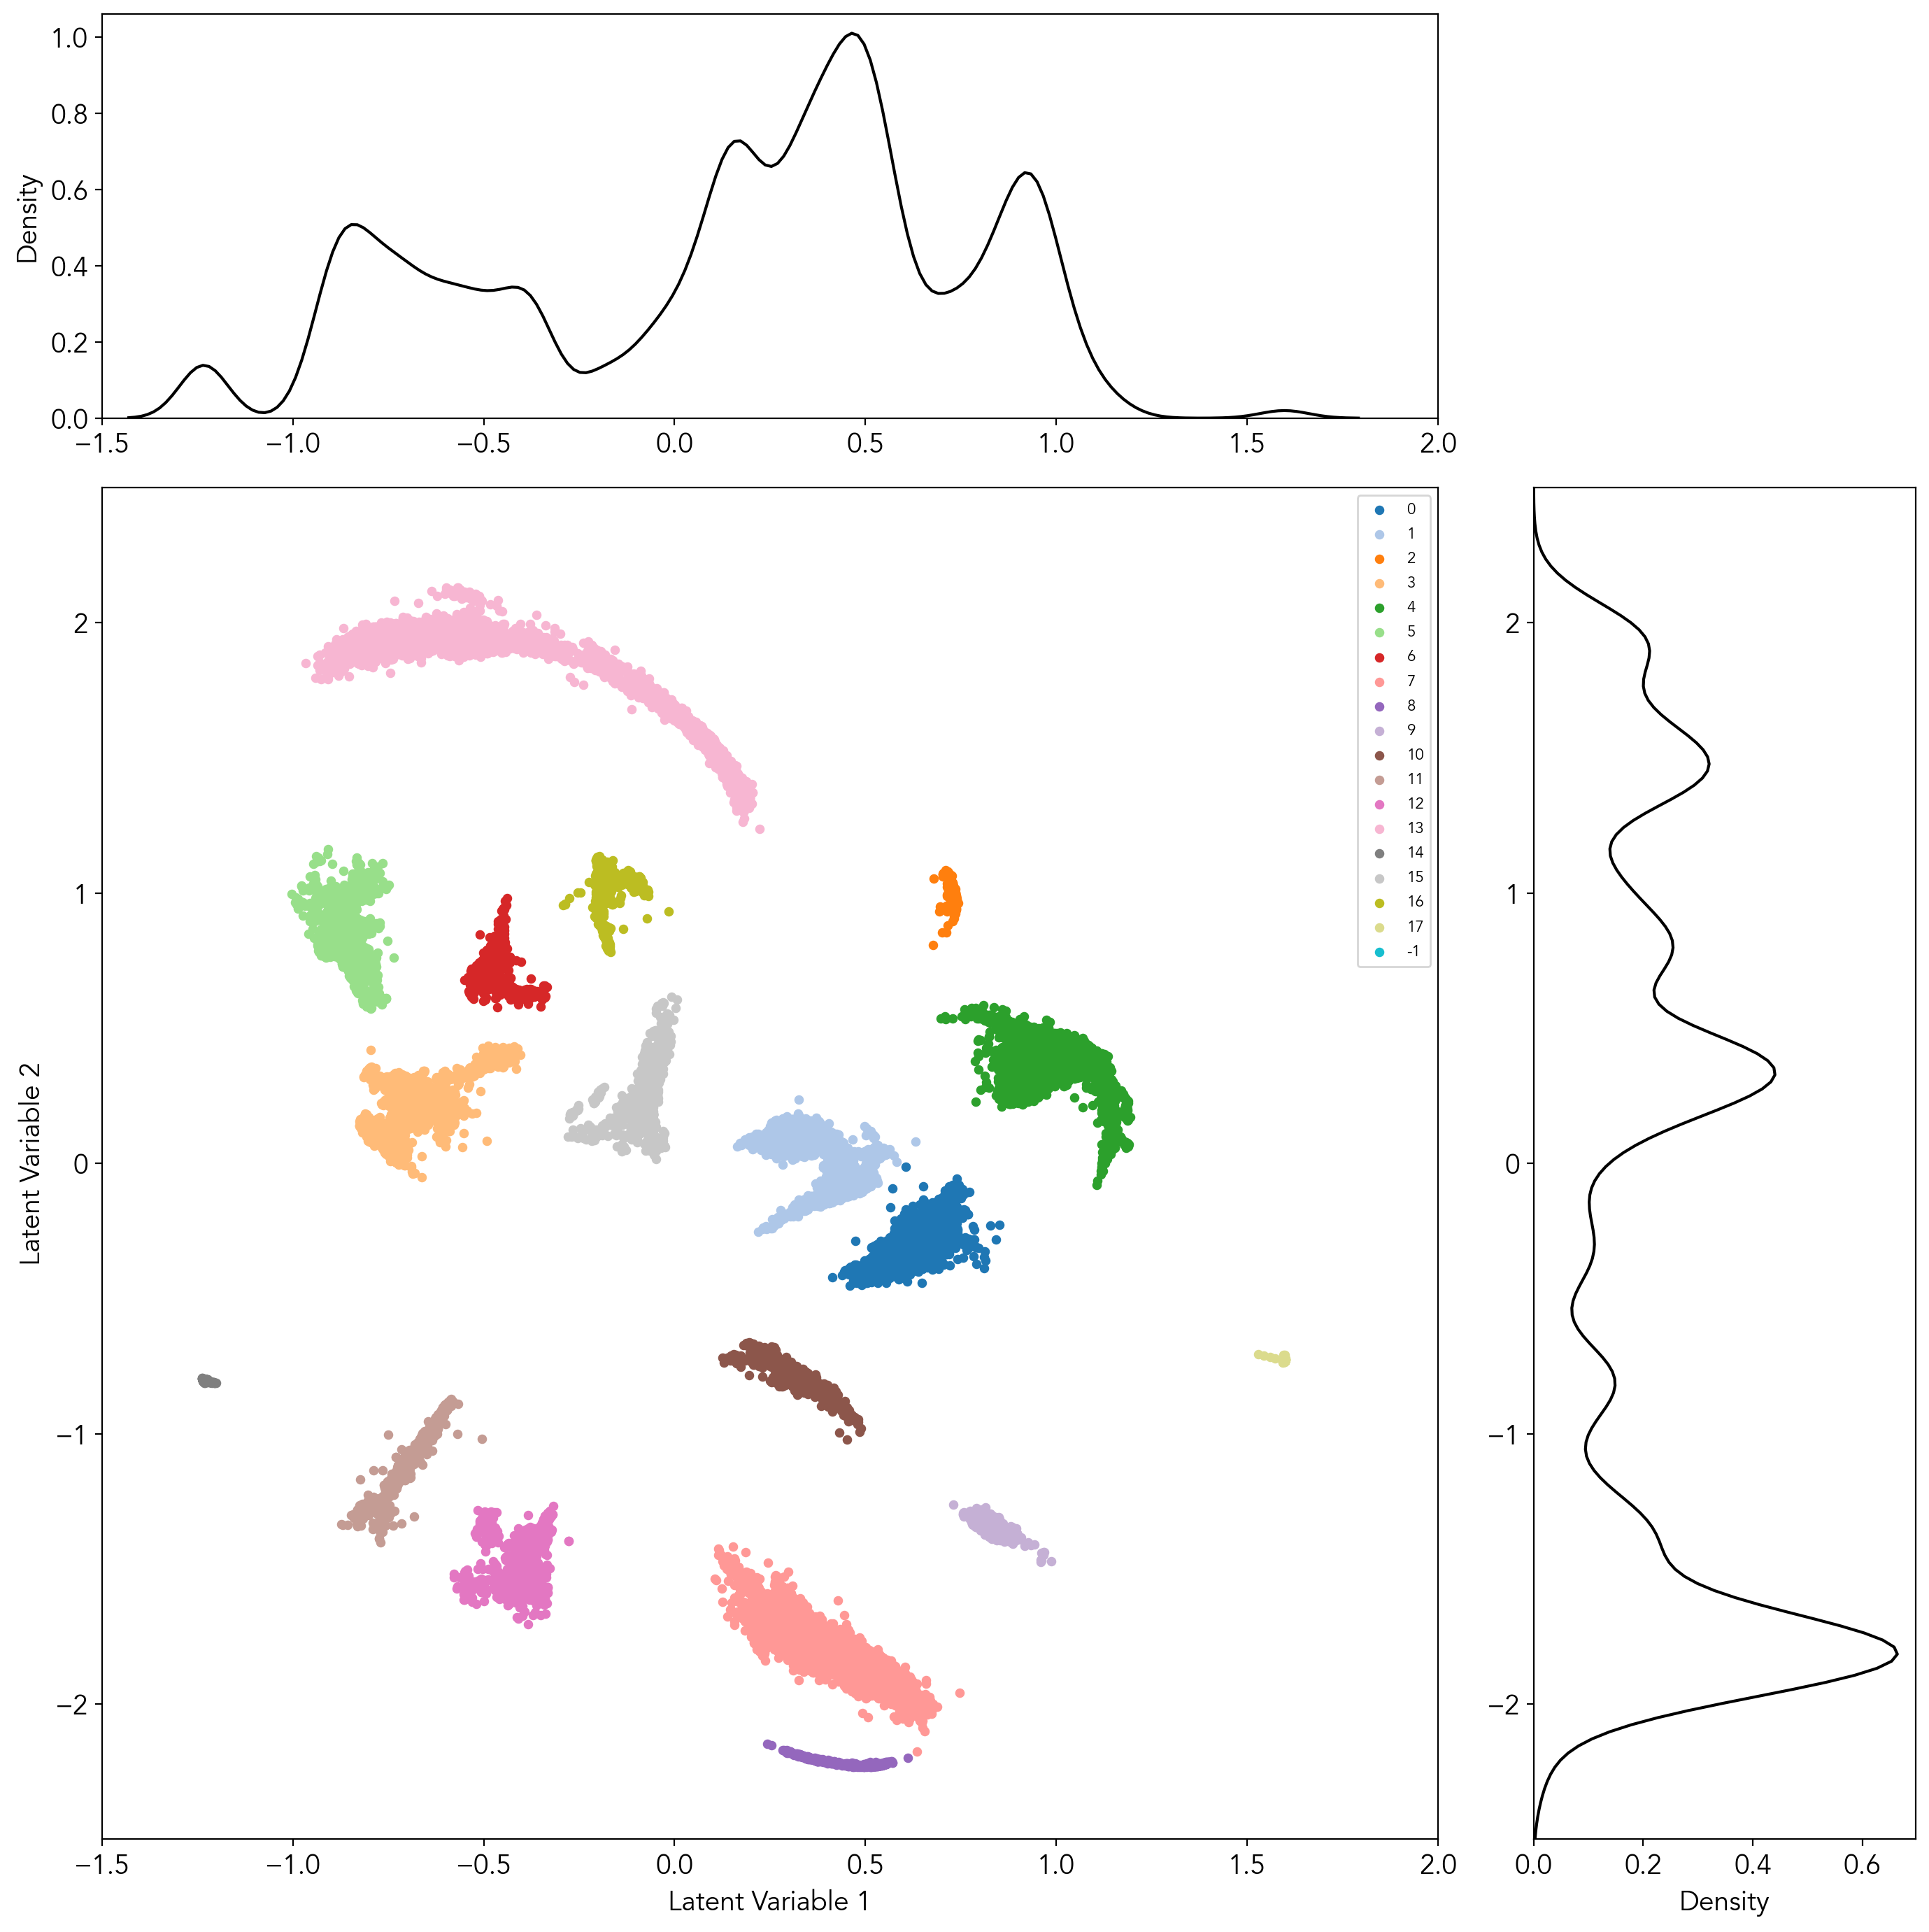

In [8]:
labels = cluster(z, 0, 'dbscan', plot = False, plot_return = False, elements = None,
    df_shape = None)

name = 'mindf_256_64_16'

z = np.load('ParameterMatrix/' + name + '_tanh.npz')['z']

z_scores_df = pd.DataFrame(columns = ['LV1', 'LV2']) 
z_scores_df['LV1'] = z[:,0]
z_scores_df['LV2'] = z[:,1]

fig = plt.figure(figsize = (14, 14))
gs = GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

phase = list(set(df['Mineral']))
tab = plt.get_cmap('tab20')
label_plot = list(set(labels))
cNorm  = mcolors.Normalize(vmin=0, vmax=len(label_plot))
labelscalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)

for i in range(len(label_plot)):
    indx = labels == i
    ax_scatter.scatter(z[indx, 0], z[indx, 1], s=15, color=labelscalarMap.to_rgba(i), lw=1, label=label_plot[i])
ax_scatter.set_xlabel("Latent Variable 1")
ax_scatter.set_ylabel("Latent Variable 2")
ax_scatter.set_xlim([-1.5, 2.0])
ax_scatter.set_ylim([-2.5, 2.5])
ax_scatter.legend(prop={'size': 8})

pc1_sns = sns.kdeplot(data = z_scores_df, x = 'LV1', color = 'k', ax = ax_hist_x)
pc1_sns.set_xlim([-1.5, 2.0])
pc1_sns.set(xlabel = None)

pc2_sns = sns.kdeplot(data = z_scores_df, y = 'LV2', color = 'k')
pc2_sns.set_ylim([-2.5, 2.5])
pc2_sns.set(ylabel = None)

plt.tight_layout()
# plt.savefig(name + "_density.pdf")

Clustering processing time (s): 33.73603582382202


meta NOT subset; don't know how to subset; dropped


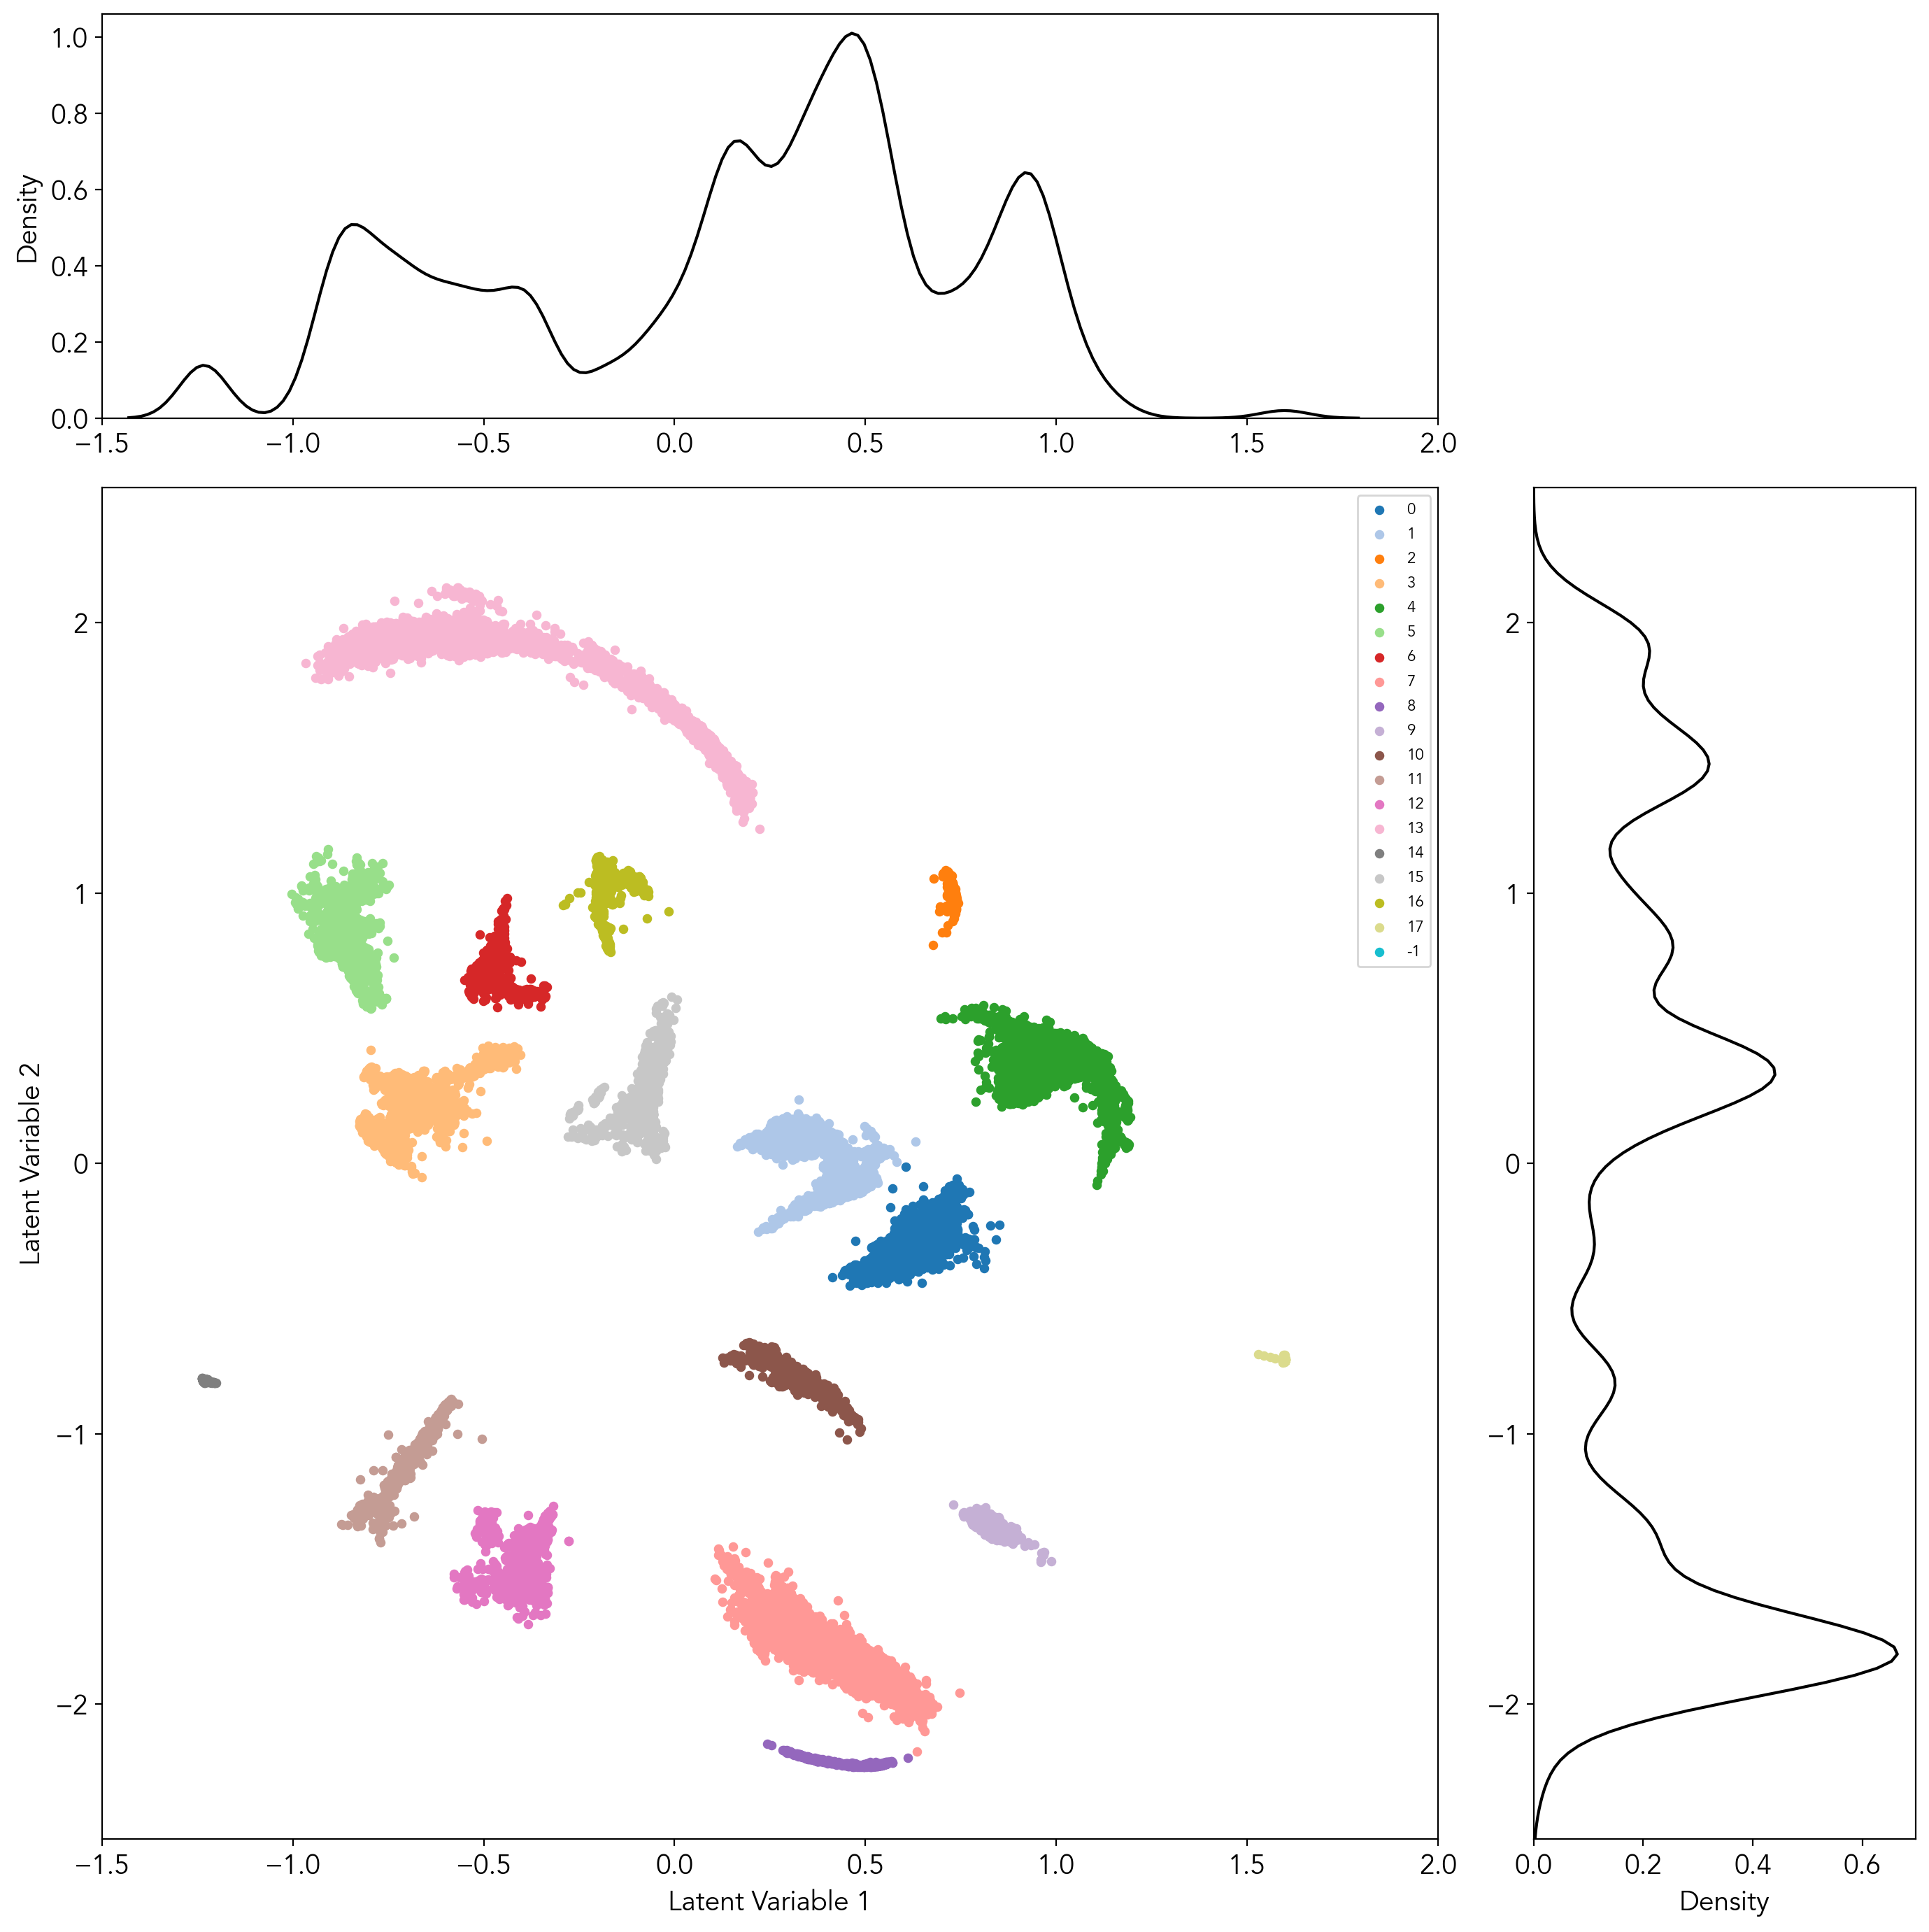

In [10]:
labels = cluster(z, 0, 'dbscan', plot = False, plot_return = False, elements = None,
    df_shape = None)

name = 'mindf_256_64_16'

z = np.load('ParameterMatrix/' + name + '_tanh.npz')['z']

z_scores_df = pd.DataFrame(columns = ['LV1', 'LV2']) 
z_scores_df['LV1'] = z[:,0]
z_scores_df['LV2'] = z[:,1]

fig = plt.figure(figsize = (14, 14))
gs = GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

phase = list(set(df['Mineral']))
tab = plt.get_cmap('tab20')
label_plot = list(set(labels))
cNorm  = mcolors.Normalize(vmin=0, vmax=len(label_plot))
labelscalarMap = mcm.ScalarMappable(norm=cNorm, cmap=tab)

for i in range(len(label_plot)):
    indx = labels == i
    ax_scatter.scatter(z[indx, 0], z[indx, 1], s=15, color=labelscalarMap.to_rgba(i), lw=1, label=label_plot[i], rasterized = True)
ax_scatter.set_xlabel("Latent Variable 1")
ax_scatter.set_ylabel("Latent Variable 2")
ax_scatter.set_xlim([-1.5, 2.0])
ax_scatter.set_ylim([-2.5, 2.5])
ax_scatter.legend(prop={'size': 8})

pc1_sns = sns.kdeplot(data = z_scores_df, x = 'LV1', color = 'k', ax = ax_hist_x)
pc1_sns.set_xlim([-1.5, 2.0])
pc1_sns.set(xlabel = None)

pc2_sns = sns.kdeplot(data = z_scores_df, y = 'LV2', color = 'k')
pc2_sns.set_ylim([-2.5, 2.5])
pc2_sns.set(ylabel = None)

plt.tight_layout()
plt.savefig(name + "_density_dbscan.pdf")